In [1]:
%pip install -q -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
from database import (
    engine_DW,
    engine_staging,
    db_staging,
    db_DW,

    table_staging_marine_name,
    table_staging_meteo_name,

    table_facts_marine_name,
    table_facts_meteo_name,

    table_dim_station_name,
    table_dim_time_name)

from imports import *
from functions import *

%load_ext autoreload
%autoreload 1

Connexion réussie à la base de données DW!
Connexion réussie à la base de données Staging!
Tables créées avec succès!


# Extraction

Get Available Stations ID List

In [3]:
# get all stations and some metadata as a Pandas DataFrame
stations_df = api.stations()
# parse the response as a dictionary
stations_df = api.stations(as_df=True)

print(len(stations_df))

146


Filter Buoys by Remarks

In [4]:
access_error_url_list = []

# Liste de mots à rechercher dans la colonne "Remark"
blacklist = ["Failure", "ceased", "failed", "recovered", "stopped", 'adrift']
stations_id_set = set()

print(f'Avant Filtre: {stations_df.shape[0]}')

# Liste pour collecter les indices à supprimer
indices_a_supprimer = []

# Parcours des lignes de la DataFrame
for idx, row in stations_df.iterrows():
    # Creation de l'url via la station ID
    station_id = row["Station"]
    url = r"https://www.ndbc.noaa.gov/station_page.php?station="+str(station_id)
    #creation
    station_Location = row["Hull No./Config and Location"]  # Extraire la valeur de la cellule pour chaque ligne
    
    # Extraction du nom de la station si un ")" est trouvé
    if ")" in station_Location:
        station_name = station_Location.split(')')[1].rstrip(" )")  # On enlève l'espace et la parenthèse en fin de chaîne
    else:
        station_name = station_Location.strip()  # Si pas de ")", on garde toute la chaîne

    station_name = station_name.rstrip(" )").replace("(", "").replace(")", "").strip()

    # Nettoyage final pour enlever toute parenthèse ou espace en fin de nom
    station_name = station_name.rstrip(" )")

    # Vérifier si "Remark" n'est pas NaN et si un des éléments de blacklist est dans "Remark"
    if isinstance(row["Remark"], str) and any(blacklist_word.lower() in row["Remark"].lower() for blacklist_word in blacklist):
        # Ajouter l'index à la liste
        indices_a_supprimer.append(idx)
        url = get_buoy_url(station_id)
        access_error_url_list.append(url)
    else:
        pass
# Supprimer les lignes après la boucle
stations_df.drop(index=indices_a_supprimer, inplace=True)

print("\n🌊 Bouées rejetées (URLs):")
for url in access_error_url_list:
    print(url)

print(f'Après Filtre: {stations_df.shape[0]}')

Avant Filtre: 146

🌊 Bouées rejetées (URLs):
https://www.ndbc.noaa.gov/station_page.php?station=41001
https://www.ndbc.noaa.gov/station_page.php?station=41009
https://www.ndbc.noaa.gov/station_page.php?station=41025
https://www.ndbc.noaa.gov/station_page.php?station=41041
https://www.ndbc.noaa.gov/station_page.php?station=41048
https://www.ndbc.noaa.gov/station_page.php?station=42039
https://www.ndbc.noaa.gov/station_page.php?station=42040
https://www.ndbc.noaa.gov/station_page.php?station=42055
https://www.ndbc.noaa.gov/station_page.php?station=44005
https://www.ndbc.noaa.gov/station_page.php?station=44008
https://www.ndbc.noaa.gov/station_page.php?station=44017
https://www.ndbc.noaa.gov/station_page.php?station=44018
https://www.ndbc.noaa.gov/station_page.php?station=44066
https://www.ndbc.noaa.gov/station_page.php?station=45001
https://www.ndbc.noaa.gov/station_page.php?station=45002
https://www.ndbc.noaa.gov/station_page.php?station=45003
https://www.ndbc.noaa.gov/station_page.php?

Get HTML from buoys that failed the test

In [5]:
DICT_SECTIONS = {}

for url in access_error_url_list:
    try:
        # Extraction de l'identifiant de la bouée depuis l'URL
        buoy_id = url.split("=")[1]
        DICT_SECTIONS[buoy_id] = {}

        # Requête HTTP vers la page de la bouée
        response = requests.get(url, timeout=5)
        soup = BeautifulSoup(response.content, "html.parser")

        # Recherche de la section spécifique contenant les métadonnées
        section_metadata = soup.find("section", id="stationmetadata", class_="metadata")
        
        if section_metadata:
            print(f"✅ Metadata trouvée pour {buoy_id}")
            DICT_SECTIONS[buoy_id]["html"] = section_metadata
        else:
            print(f"❌ Aucune metadata trouvée pour {buoy_id}")

    except Exception as e:
        print(f"❌ Erreur pour {buoy_id} : {str(e)}")



✅ Metadata trouvée pour 41001
✅ Metadata trouvée pour 41009
✅ Metadata trouvée pour 41025
✅ Metadata trouvée pour 41041
✅ Metadata trouvée pour 41048
✅ Metadata trouvée pour 42039
✅ Metadata trouvée pour 42040
✅ Metadata trouvée pour 42055
✅ Metadata trouvée pour 44005
✅ Metadata trouvée pour 44008
✅ Metadata trouvée pour 44017
✅ Metadata trouvée pour 44018
✅ Metadata trouvée pour 44066
✅ Metadata trouvée pour 45001
✅ Metadata trouvée pour 45002
✅ Metadata trouvée pour 45003
✅ Metadata trouvée pour 45004
✅ Metadata trouvée pour 45005
✅ Metadata trouvée pour 45006
✅ Metadata trouvée pour 45007
✅ Metadata trouvée pour 45008
✅ Metadata trouvée pour 45012
✅ Metadata trouvée pour 46002
✅ Metadata trouvée pour 46005
✅ Metadata trouvée pour 46006
✅ Metadata trouvée pour 46011
✅ Metadata trouvée pour 46012
✅ Metadata trouvée pour 46013
✅ Metadata trouvée pour 46015
✅ Metadata trouvée pour 46026
✅ Metadata trouvée pour 46027
✅ Metadata trouvée pour 46028
✅ Metadata trouvée pour 46035
✅ Metadata

In [6]:

# Choisir un buoy_id au hasard dans le dictionnaire
random_buoy_id = random.choice(list(DICT_SECTIONS.keys()))
section_html = DICT_SECTIONS[random_buoy_id].get("html")

# URL de base pour les images
base_url = f"https://www.ndbc.noaa.gov/station_page.php?station={random_buoy_id}"

if section_html:
    # Convertir en objet BeautifulSoup si ce n’est pas déjà fait
    soup = BeautifulSoup(str(section_html), "html.parser")

    # Convertir tous les liens <img src="..."> en absolu
    for img in soup.find_all("img"):
        if img.has_attr("src"):
            img["src"] = urljoin(base_url, img["src"])

    print(f"🎯 Bouée sélectionnée : {random_buoy_id}")
    display(HTML(str(soup)))
else:
    print(f"⚠️ Pas de contenu HTML pour la bouée {random_buoy_id}")


🎯 Bouée sélectionnée : 46011


In [7]:
stations_df.head()

,Station,Hull No./Config and Location,Location Lat/Long,Wind Speed,Wind Direction,Sea Level Pressure,Wave Height,Dominant Period,Air Temp,Water Temp,Dew Point,Remark
2,41004,3DV02 (SC) Edisto,32.50N 79.08W,100,100,100,100,100,100,97,100,Dewpoint is intermittent.
3,41008,3D36 (SC) Grays Reef,31.40N 80.85W,100,100,100,100,100,100,98,100,All data is intermittent after 8/18/23.
11,41044,3D70 (SC) Ne St Martin,21.57N 58.62W,100,100,100,100,100,100,98,100,NaN
12,41046,3DV09 (SC) East Bahamas,23.85N 68.33W,86,86,86,85,85,86,84,86,New buoy deployed 4/22/25.
15,41049,3DV17 (SC) South Bermuda,27.50N 62.27W,100,100,100,100,100,100,98,100,NaN


Build Buoys_datas Dict

In [8]:
# Dictionnaire pour stocker les DataFrames, clé : ID de la bouée, valeur : DataFrame
buoy_datas = {}
buoy_list = []

# Parcours de chaque bouée dans stations_df
for index, row in stations_df.iterrows():
    buoy_id = row['Station']
    metadata = get_station_metadata(buoy_id)

    # ✅ Récupérer les données sous forme de dictionnaire
    buoy_info = parse_buoy_json(metadata)

    # ✅ Stocker directement les données dans buoy_datas
    buoy_datas[buoy_id] = buoy_info
    buoy_list.append(buoy_id)

# Affichage du nombre de bouées réussies et échouées
print(f"Nombre de bouées traitées : {len(buoy_datas)}\n")

# Afficher le contenu de buoy_datas

first_key =next(iter(buoy_datas))
first_key
buoy_datas[first_key]


🔍 Début du parsing de la bouée...
🌍 Zone de la station : edisto
🆔 Station ID : 41004
✅ Coordonnées extraites : Latitude = 32.50N, Longitude = 79.10W
🌊 Water Depth : 35 m
🌡️ Sea Temp Depth : 1.5
🌬️ Barometer Elevation (m): 2.7
💨 Anemometer Height : 4.1
🌤️ Air Temp Height : 3.7
🔗 URL de la bouée : https://www.ndbc.noaa.gov/station_page.php?station=41004
✅ Parsing terminé !


🔍 Début du parsing de la bouée...
🌍 Zone de la station : grays reef
🆔 Station ID : 41008
✅ Coordonnées extraites : Latitude = 31.40N, Longitude = 80.87W
🌊 Water Depth : 16 m
🌡️ Sea Temp Depth : 2
🌬️ Barometer Elevation (m): 2.4
💨 Anemometer Height : 3.8
🌤️ Air Temp Height : 3.4
🔗 URL de la bouée : https://www.ndbc.noaa.gov/station_page.php?station=41008
✅ Parsing terminé !


🔍 Début du parsing de la bouée...
🌍 Zone de la station : ne st martin
🆔 Station ID : 41044
✅ Coordonnées extraites : Latitude = 21.58N, Longitude = 58.63W
🌊 Water Depth : 5419 m
🌡️ Sea Temp Depth : 2
🌬️ Barometer Elevation (m): 2.4
💨 Anemometer 

{'station_zone': 'edisto',
 'lat_buoy': '32.50N',
 'lon_buoy': '79.10W',
 'Water_depth': '35 m',
 'sea_temp_depth': '1.5',
 'Barometer_elevation': '2.7',
 'Anemometer_height': '4.1',
 'Air_temp_height': '3.7',
 'url': 'https://www.ndbc.noaa.gov/station_page.php?station=41004'}

In [9]:
from IPython.display import display, HTML

import folium

# Liste pour stocker les coordonnées
coordinates = []

# Remplir la liste avec les coordonnées converties
for buoy_id, value in buoy_datas.items():
    Water_depth = value["Water_depth"]
    station_zone = value["station_zone"]
    lat = value["lat_buoy"]
    lon = value["lon_buoy"]
    
    lat, lon = convert_to_decimal(lat, lon)
    coordinates.append((lat, lon, Water_depth, station_zone, buoy_id))

# Calcul du centre de la carte
avg_lat = sum(coord[0] for coord in coordinates) / len(coordinates)
avg_lon = sum(coord[1] for coord in coordinates) / len(coordinates)

# Création de la carte avec zoom 2.5, sans attribution visible
map_center = folium.Map(
    location=[avg_lat, avg_lon],
    zoom_start=2.5,
    tiles=None
)

# Ajouter les tuiles Esri sans attribution visible
folium.TileLayer(
    tiles="https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}",
    attr="&nbsp;",  # Astuce pour éviter l'affichage de l'attribution
    name="Esri Imagery",
    control=False
).add_to(map_center)

# Ajouter les marqueurs
for lat, lon, Water_depth, station_zone, buoy_id in coordinates:
    popup = folium.Popup(f"ID: {buoy_id}<br>Zone: {station_zone}<br>Water Depth: {Water_depth} meters", max_width=300)
    folium.Marker([lat, lon], popup=popup).add_to(map_center)

# CSS pour masquer l'attribution
hide_leaflet_css = """
<style>
.leaflet-control-attribution {
    display: none !important;
}
</style>
"""

# Injecter le CSS et afficher la carte
display(HTML(hide_leaflet_css))
display(map_center)


Collecte des données marines et météos

In [10]:
# 🚀 Démarrage du processus
print("\n🚀 Démarrage du processus de collecte des données...\n")

# Initialisation des compteurs
marine_data_collected_successfully = marine_data_collected_failed = 0
meteo_data_collected_successfully = meteo_data_collected_failed = 0

success = False
total_stations = stations_df.shape[0]
count = 0

# 🔄 Parcours des bouées / stations
for idx, row in stations_df.iterrows():
    buoy_id = row["Station"]

    ######### 🌊 MARINE DATA #########
    try:
        df_marine = NDBC.realtime_observations(buoy_id)
        if df_marine is None or df_marine.empty:
            marine_data_collected_failed += 1
            continue

        marine_data_collected_successfully += 1
    except Exception as e:
        print(f"⚠️ Erreur collecte marine {buoy_id}: {e}")
        marine_data_collected_failed += 1
        continue

    # Ajout des métadonnées
    try:
        buoy_info = buoy_datas.get(buoy_id, {})
        Lat, Lon = buoy_info.get('lat_buoy'), buoy_info.get('lon_buoy')
        if Lat is None or Lon is None:
            raise ValueError(f"Données manquantes pour {buoy_id}")

        df_marine['Lat'] = Lat
        df_marine['Lon'] = Lon
        df_marine['Water_depth'] = buoy_info.get('Water_depth', None)
        df_marine.columns = ['Datetime' if 'date' in col.lower() or 'time' in col.lower() else col for col in df_marine.columns]
        df_marine['Datetime'] = df_marine['Datetime'].dt.tz_localize(None)

        buoy_datas[buoy_id]["Marine"] = df_marine

        station_zone = safe_get(parse_buoy_json(get_station_metadata(buoy_id)), "station_zone")
        Bronze_Marine_table_Name = f"br_{buoy_id}_marine_{station_zone}".replace('.', '_').replace('-', '_').replace(' ', '_').lower()

    except Exception as e:
        print(f"⚠️ Erreur métadonnées marine {buoy_id}: {e}")
        marine_data_collected_failed += 1
        continue

    ######### ⛅ METEO DATA #########
    try:
        df_meteo = meteo_api_request([Lat, Lon])
        if df_meteo is None or df_meteo.empty:
            meteo_data_collected_failed += 1
            continue
        
        rename_columns(df_meteo, {'date':'Datetime'})
        df_meteo.columns = ['Datetime' if 'date' in col.lower() or 'time' in col.lower() else col for col in df_meteo.columns]
        df_meteo['Datetime'] = df_meteo['Datetime'].dt.tz_localize(None)
    
        buoy_datas[buoy_id]["Meteo"] = df_meteo
        meteo_data_collected_successfully += 1
    except Exception as e:
        print(f"⚠️ Erreur collecte météo {buoy_id}: {e}")
        meteo_data_collected_failed += 1
        continue

# Retirer les bouées avec des DataFrames vides ou None
buoy_datas = {buoy_id: data for buoy_id, data in buoy_datas.items() 
              if "Marine" in data and data["Marine"] is not None and not data["Marine"].empty
              and "Meteo" in data and data["Meteo"] is not None and not data["Meteo"].empty}

# 🔚 Résumé final

print("\n📝 Résumé final :")
print(f"🌊 Marine - Collecte ✅ {marine_data_collected_successfully} ❌ {marine_data_collected_failed}")
print(f"⛅ Météo - Collecte ✅ {meteo_data_collected_successfully} ❌ {meteo_data_collected_failed}")

# Afficher la longueur du dictionnaire (nombre de bouées avec des données valides)
print(f"\n📊 Nombre de bouées avec des données valides : {len(buoy_datas)}")


🚀 Démarrage du processus de collecte des données...


🔍 Début du parsing de la bouée...
🌍 Zone de la station : edisto
🆔 Station ID : 41004
✅ Coordonnées extraites : Latitude = 32.50N, Longitude = 79.10W
🌊 Water Depth : 35 m
🌡️ Sea Temp Depth : 1.5
🌬️ Barometer Elevation (m): 2.7
💨 Anemometer Height : 4.1
🌤️ Air Temp Height : 3.7
🔗 URL de la bouée : https://www.ndbc.noaa.gov/station_page.php?station=41004
✅ Parsing terminé !

📊 station_zone : edisto
🔄 Colonne 'date' renommée en 'Datetime'
✅ Colonnes renommées : {'date': 'Datetime'}

🔍 Début du parsing de la bouée...
🌍 Zone de la station : grays reef
🆔 Station ID : 41008
✅ Coordonnées extraites : Latitude = 31.40N, Longitude = 80.87W
🌊 Water Depth : 16 m
🌡️ Sea Temp Depth : 2
🌬️ Barometer Elevation (m): 2.4
💨 Anemometer Height : 3.8
🌤️ Air Temp Height : 3.4
🔗 URL de la bouée : https://www.ndbc.noaa.gov/station_page.php?station=41008
✅ Parsing terminé !

📊 station_zone : grays reef
🔄 Colonne 'date' renommée en 'Datetime'
✅ Colonnes renom

Data Enrichment with MetaDatas

In [11]:
list_not_include = ['lon_buoy', "lat_buoy", "url"]

list_df_marine = []
list_df_meteo = []

for buoy_id, value in buoy_datas.items():
    print(f"\n🔍 Traitement de la Station ID: {buoy_id}")

    marine_df = buoy_datas[buoy_id]["Marine"]
    list_df_marine.append(marine_df)
    meteo_df = buoy_datas[buoy_id]["Meteo"]
    list_df_meteo.append(meteo_df)

    try:
        # Récupérer les métadonnées de la station
        buoy_metadata = get_station_metadata(buoy_id)
        parsed_data = parse_buoy_json(buoy_metadata)

        # Mise à jour du dictionnaire avec les métadonnées
        data = buoy_datas[buoy_id]
        data.update(parsed_data)
        
        # Ajouter les métadonnées comme nouvelles colonnes dans marine_df
        if marine_df is not None:
            marine_df["Station ID"] = str(buoy_id)
            for key, value in parsed_data.items():
                # Vérifier si la clé n'est pas dans la liste des exclusions
                if key not in list_not_include:
                    marine_df[key] = value
                    print(f"✅ Colonne '{key}' ajoutée au DataFrame de la station {buoy_id}")

    except Exception as e:
        print(f"❌ Erreur pour la station {buoy_id}: {e}")

# Vérification de l'ajout des colonnes en prenant un id au hasard
station_id = random.choice(list(buoy_datas.keys()))
marine_df = buoy_datas[station_id]["Marine"]

if marine_df is not None:
    print("\nColonnes ajoutées au DataFrame de la station", station_id)
    print(marine_df.columns)


🔍 Traitement de la Station ID: 41004

🔍 Début du parsing de la bouée...
🌍 Zone de la station : edisto
🆔 Station ID : 41004
✅ Coordonnées extraites : Latitude = 32.50N, Longitude = 79.10W
🌊 Water Depth : 35 m
🌡️ Sea Temp Depth : 1.5
🌬️ Barometer Elevation (m): 2.7
💨 Anemometer Height : 4.1
🌤️ Air Temp Height : 3.7
🔗 URL de la bouée : https://www.ndbc.noaa.gov/station_page.php?station=41004
✅ Parsing terminé !

✅ Colonne 'station_zone' ajoutée au DataFrame de la station 41004
✅ Colonne 'Water_depth' ajoutée au DataFrame de la station 41004
✅ Colonne 'sea_temp_depth' ajoutée au DataFrame de la station 41004
✅ Colonne 'Barometer_elevation' ajoutée au DataFrame de la station 41004
✅ Colonne 'Anemometer_height' ajoutée au DataFrame de la station 41004
✅ Colonne 'Air_temp_height' ajoutée au DataFrame de la station 41004

🔍 Traitement de la Station ID: 41008

🔍 Début du parsing de la bouée...
🌍 Zone de la station : grays reef
🆔 Station ID : 41008
✅ Coordonnées extraites : Latitude = 31.40N, L

In [12]:
display_buoys_missing_df_counts(buoy_datas)


🌊 Nombre de bouées sans données 'Marine' : 0/45

☁️ Nombre de bouées sans données 'Meteo' : 0/45


In [13]:
display(df_marine.columns)
display(df_meteo.columns)

Index(['wind_direction', 'wind_speed', 'wind_gust', 'wave_height',
       'dominant_wave_period', 'average_wave_period',
       'dominant_wave_direction', 'pressure', 'air_temperature',
       'water_temperature', 'dewpoint', 'visibility', '3hr_pressure_tendency',
       'water_level_above_mean', 'Datetime', 'Lat', 'Lon', 'Water_depth',
       'Station ID', 'station_zone', 'sea_temp_depth', 'Barometer_elevation',
       'Anemometer_height', 'Air_temp_height'],
      dtype='object')

Index(['Datetime', 'temperature_2m', 'relative_humidity_2m', 'dew_point_2m',
       'precipitation', 'rain', 'showers', 'pressure_msl', 'surface_pressure',
       'cloud_cover', 'cloud_cover_low', 'cloud_cover_mid', 'cloud_cover_high',
       'visibility', 'wind_speed_10m', 'soil_temperature_0cm',
       'soil_moisture_0_to_1cm', 'is_day'],
      dtype='object')

# Transformation

Handle Null Values

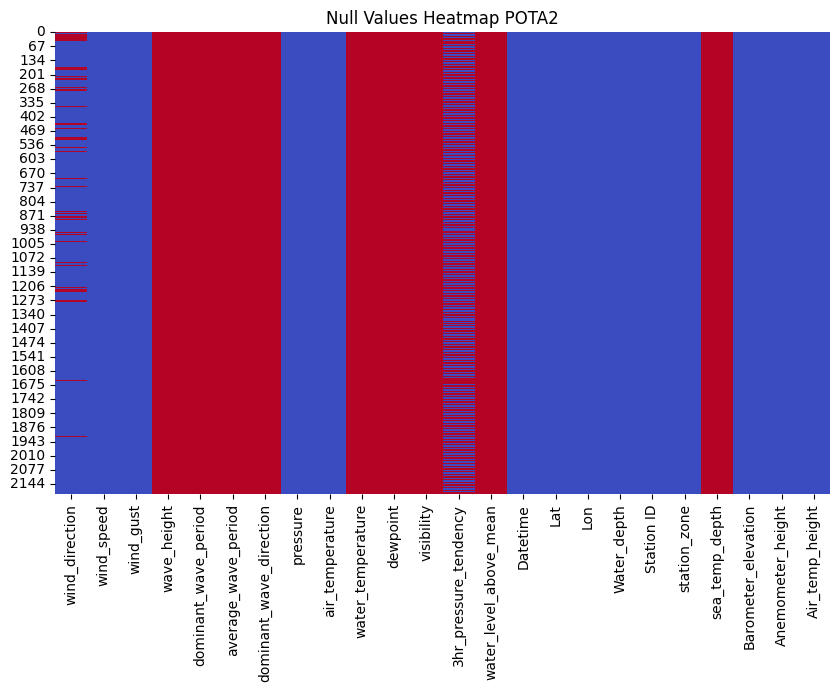

In [14]:
df_marine_random = random.choice(list_df_marine)


# Marine null values heatmap
plt.figure(figsize=(10, 6))

sns.heatmap(df_marine_random.isnull(), cbar=False, cmap='coolwarm')

plt.title(f'Null Values Heatmap {df_marine_random['Station ID'][0]}')

plt.show()

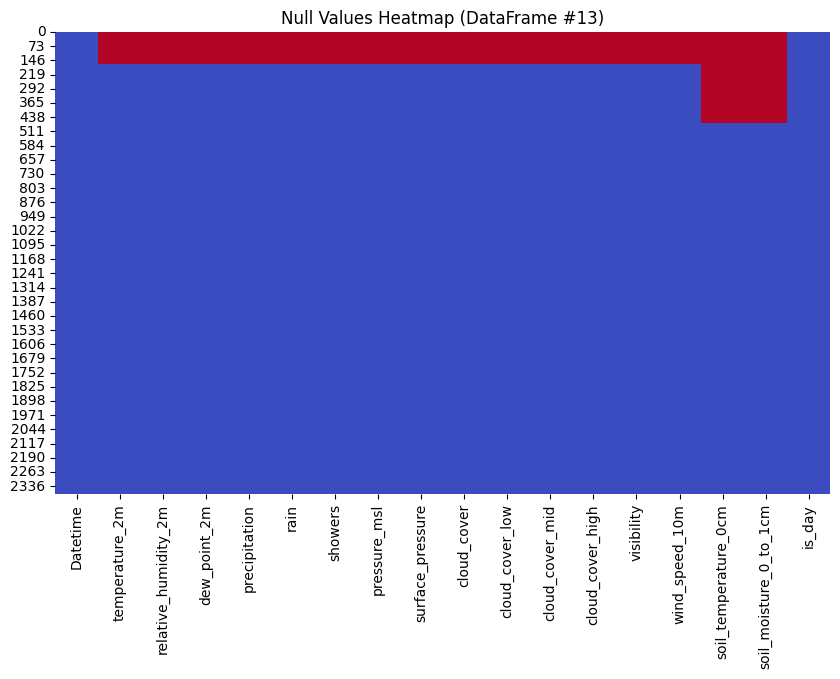

In [15]:
# Sélectionner une DataFrame aléatoire et récupérer son index
random_index = random.randint(0, len(list_df_meteo) - 1)
df_meteo_random = list_df_meteo[random_index]

# Marine null values heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df_meteo_random.isnull(), cbar=False, cmap='coolwarm')
plt.title(f'Null Values Heatmap (DataFrame #{random_index})')
plt.show()


In [16]:
important_columns_oceanography = [
    'wind_direction',             
    'wind_speed',                 
    'wave_height',                   
    'pressure',                   
    'air_temperature',            
    'water_temperature',          
    'Datetime',
    'Lat',
    'Lon'                 
]

important_columns_meteorology = [
    'temperature_2m',             
    'relative_humidity_2m',       
    'dew_point_2m',               
    'precipitation',              
    'pressure_msl',               
    'cloud_cover',                
    'wind_speed_10m',             
    'Datetime'
]

initial_meteo_data_count = 0
initial_marine_data_count = 0

marine_data_after_cleaning = 0
meteo_data_after_cleaning = 0

stations_depart = len(buoy_datas)
ignored_buoys = {}  # Dictionary to track ignored buoys and their reasons

for station_id, data in buoy_datas.items():
    print(f"\n🔄 Nettoyage des données pour la station {station_id}")

    marine_df = data.get("Marine")
    meteo_df = data.get("Meteo")

    if marine_df is None or meteo_df is None:
        ignored_buoys[station_id] = "Marine DataFrame ou Meteo DataFrame manquant(e)"
        print(f"⚠️ Station {station_id} ignorée: Marine DataFrame ou Meteo DataFrame manquant(e)")
        continue

    initial_marine_data_count += marine_df.shape[0]
    initial_meteo_data_count += meteo_df.shape[0]

    try:
        # Nettoyage des DataFrames
        cleaned_marine_df = handle_null_values(marine_df)
        cleaned_meteo_df = handle_null_values(meteo_df)
        # Vérification des colonnes importantes après nettoyage
        marine_columns_ok = all(col in cleaned_marine_df.columns for col in important_columns_oceanography)
        meteo_columns_ok = all(col in cleaned_meteo_df.columns for col in important_columns_meteorology)

        # Track which columns are missing
        missing_marine_columns = [col for col in important_columns_oceanography if col not in cleaned_marine_df.columns]
        missing_meteo_columns = [col for col in important_columns_meteorology if col not in cleaned_meteo_df.columns]

        if missing_marine_columns or missing_meteo_columns:
            ignored_buoys[station_id] = f"Colonnes manquantes: Marine: {missing_marine_columns}, Meteo: {missing_meteo_columns}"
            print(f"⚠️ Station {station_id} ignorée: Colonnes manquantes - Marine: {missing_marine_columns}, Meteo: {missing_meteo_columns}")
            continue

        # Ajouter le DataFrame nettoyé au dictionnaire des résultats
        buoy_datas[station_id]['Cleaned Marine'] = cleaned_marine_df
        buoy_datas[station_id]['Cleaned Meteo'] = cleaned_meteo_df
        print(f"✅ Nettoyage réussi pour la station {station_id} ({cleaned_marine_df.shape[0]} lignes)")

        marine_data_after_cleaning += cleaned_marine_df.shape[0]
        meteo_data_after_cleaning += cleaned_meteo_df.shape[0]
        

    except Exception as e:
        ignored_buoys[station_id] = f"Erreur lors du nettoyage: {e}"
        print(f"❌ Erreur lors du nettoyage pour {station_id}: {e}")

# 🔥 Suppression des stations ignorées du dictionnaire principal
for station_id in ignored_buoys:
    buoy_datas.pop(station_id, None)

len_cleaned_data = len([data for data in buoy_datas.values() if 'Cleaned Marine' in data and 'Cleaned Meteo' in data])

# Résumé final du nettoyage
print("\n📊 RÉSUMÉ DU NETTOYAGE:")
print(f"📌 Stations au départ : {stations_depart}")
print(f"✅ Stations nettoyées : {len_cleaned_data}")
print(f"🏁 Stations restantes après filtrage :")

for station_id, reason in ignored_buoys.items():
    print(f"🛑 Station {station_id} ignorée: {reason}")

print(f"\n🧹 Clés restantes dans buoy_datas après purge : {len(buoy_datas)} (attendu : {len_cleaned_data})")


print(f"\n📊 Nombre de données initiales : Marine: {initial_marine_data_count}, Météo: {initial_meteo_data_count}")
print(f"📊 Nombre de données après nettoyage : Marine: {marine_data_after_cleaning}, Météo: {meteo_data_after_cleaning}")


🔄 Nettoyage des données pour la station 41004

Tag: orange - Nombre de lignes: 6497
Colonne 'wind_direction' Imputée par la médiane (0.38% de valeurs manquantes)
Colonne 'wind_speed' Imputée par la médiane (0.26% de valeurs manquantes)
Colonne 'wind_gust' Imputée par la médiane (0.26% de valeurs manquantes)
Colonne 'wave_height' Imputée par la médiane (46.62% de valeurs manquantes)
Colonne 'dominant_wave_period' Supprimée (plus de 55% de valeurs manquantes)
Colonne 'average_wave_period' Imputée par la médiane (46.62% de valeurs manquantes)
Colonne 'dominant_wave_direction' Imputée par la médiane (46.62% de valeurs manquantes)
Colonne 'pressure' Imputée par la médiane (0.22% de valeurs manquantes)
Colonne 'air_temperature' Imputée par la médiane (0.28% de valeurs manquantes)
Colonne 'water_temperature' Imputée par la médiane (1.72% de valeurs manquantes)
Colonne 'dewpoint' Imputée par la médiane (0.95% de valeurs manquantes)
Colonne 'visibility' Supprimée (plus de 55% de valeurs manqua

In [17]:
display_buoys_missing_df_counts(buoy_datas, prefix="Cleaned")


🌊 Nombre de bouées sans données 'Cleaned Marine' : 0/25

☁️ Nombre de bouées sans données 'Cleaned Meteo' : 0/25


In [18]:
display_row_values(df_meteo)

Index  |  Datetime             |  temperature_2m  |  relative_humidity_2m  |  dew_point_2m  |  precipitation  |  rain  |  showers  |  pressure_msl  |  surface_pressure  |  cloud_cover  |  cloud_cover_low  |  cloud_cover_mid  |  cloud_cover_high  |  visibility  |  wind_speed_10m  |  soil_temperature_0cm  |  soil_moisture_0_to_1cm  |  is_day
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
0      |  2025-01-27 00:00:00  |  3.4850001       |  72.0                  |  -0.85         |  0.0            |  0.0   |  0.0      |  1016.0        |  991.185           |  78.5         |  9.0              |  0.0              |  0.0               |  24140.0     |  17.9            |  8.39                  |  0.3                     | 

Fusionner les df_meteo et df_marine sur 'Datetime'

In [19]:
# Fusion des DataFrames nettoyés
print("\n🔗 FUSION DES DONNÉES MARINE + METEO PAR STATION")

merged_success_count = 0  # Compteur de fusions réussies
total_merged_rows = 0     # Total de lignes fusionnées

for station_id, data in buoy_datas.items():
    print(f"\n🔄 Fusion des données pour la station {station_id}")

    cleaned_marine_df = data.get("Cleaned Marine")
    cleaned_meteo_df = data.get("Cleaned Meteo")

    if cleaned_marine_df is None or cleaned_meteo_df is None:
        continue

    try:
        merged_df = pd.merge(cleaned_marine_df, cleaned_meteo_df, on="Datetime", how="inner")

        if merged_df.empty:
            print(f"⚠️ Station {station_id} fusionnée, mais résultat vide après inner merge sur 'Datetime'")
        else:
            buoy_datas[station_id]["Merged"] = merged_df
            merged_success_count += 1
            total_merged_rows += len(merged_df)
            print(f"✅ Fusion réussie pour la station {station_id} ({merged_df.shape[0]} lignes)")

    except Exception as e:
        print(f"❌ Erreur lors de la fusion pour {station_id}: {e}")

# Résumé des fusions
print(f"\n📦 Fusions réussies : {merged_success_count}/{len_cleaned_data} stations")
print(f"📊 Total de lignes fusionnées : {total_merged_rows}")


🔗 FUSION DES DONNÉES MARINE + METEO PAR STATION

🔄 Fusion des données pour la station 41004
✅ Fusion réussie pour la station 41004 (1092 lignes)

🔄 Fusion des données pour la station 41008
✅ Fusion réussie pour la station 41008 (1098 lignes)

🔄 Fusion des données pour la station 41044
✅ Fusion réussie pour la station 41044 (1090 lignes)

🔄 Fusion des données pour la station 41046
✅ Fusion réussie pour la station 41046 (186 lignes)

🔄 Fusion des données pour la station 41049
✅ Fusion réussie pour la station 41049 (1098 lignes)

🔄 Fusion des données pour la station 42001
✅ Fusion réussie pour la station 42001 (1097 lignes)

🔄 Fusion des données pour la station 42002
✅ Fusion réussie pour la station 42002 (1095 lignes)

🔄 Fusion des données pour la station 42020
✅ Fusion réussie pour la station 42020 (1098 lignes)

🔄 Fusion des données pour la station 42036
✅ Fusion réussie pour la station 42036 (1097 lignes)

🔄 Fusion des données pour la station 42056
✅ Fusion réussie pour la station 42

In [20]:
cleaned_marine_df.head()

,wind_direction,wind_speed,wind_gust,wave_height,average_wave_period,dominant_wave_direction,pressure,air_temperature,water_temperature,dewpoint,Datetime,Lat,Lon,Water_depth,Station ID,station_zone,sea_temp_depth,Barometer_elevation,Anemometer_height,Air_temp_height
0,90.0,7.0,8.0,2.0,6.2,101.0,1017.0,25.1,25.8,21.7,2025-04-29 18:30:00,17.07N,157.75W,4979 m,51002,southwest hawaii,1.5,2.7,4.1,3.7
1,100.0,7.0,8.0,2.0,6.2,106.0,1017.0,25.1,25.8,21.5,2025-04-29 18:20:00,17.07N,157.75W,4979 m,51002,southwest hawaii,1.5,2.7,4.1,3.7
2,100.0,7.0,9.0,2.0,6.2,106.0,1016.9,25.1,25.8,21.6,2025-04-29 18:10:00,17.07N,157.75W,4979 m,51002,southwest hawaii,1.5,2.7,4.1,3.7
3,100.0,7.0,9.0,2.0,6.2,101.0,1016.7,25.0,25.8,21.5,2025-04-29 18:00:00,17.07N,157.75W,4979 m,51002,southwest hawaii,1.5,2.7,4.1,3.7
4,100.0,7.0,9.0,2.0,6.2,97.0,1016.6,25.0,25.8,21.6,2025-04-29 17:50:00,17.07N,157.75W,4979 m,51002,southwest hawaii,1.5,2.7,4.1,3.7


Concaténation des DataFrames fusionnés

In [21]:
# Concaténation des DataFrames fusionnés
print("\n🧬 CONCATÉNATION DES DONNÉES FUSIONNÉES EN UN SEUL DATAFRAME")

final_merged_df_list = []
concat_success_count = 0
concat_total_rows = 0

for station_id, data in buoy_datas.items():
    merged_df = data.get("Merged")

    if merged_df is None:
        print(f"⚠️ Station {station_id} ignorée pour concaténation: Données fusionnées manquantes")
        continue

    try:
        final_merged_df_list.append(merged_df)
        concat_success_count += 1
        concat_total_rows += len(merged_df)
        print(f"✅ Concaténation réussie pour la station {station_id} ({len(merged_df)} lignes)")

    except Exception as e:
        print(f"❌ Erreur lors de la concaténation pour {station_id}: {e}")

# Création du DataFrame final unique
try:
    df_final = pd.concat(final_merged_df_list, ignore_index=True)
    print(f"\n🧾 DataFrame final créé avec succès ({df_final.shape[0]} lignes, {df_final.shape[1]} colonnes)")
except Exception as e:
    print(f"\n❌ Erreur lors de la création du DataFrame final: {e}")
    df_final = None

# Résumé
print(f"\n📦 Concaténations réussies : {concat_success_count}/{merged_success_count}")
print(f"📊 Total de lignes dans le DataFrame final : {concat_total_rows}")


🧬 CONCATÉNATION DES DONNÉES FUSIONNÉES EN UN SEUL DATAFRAME
✅ Concaténation réussie pour la station 41004 (1092 lignes)
✅ Concaténation réussie pour la station 41008 (1098 lignes)
✅ Concaténation réussie pour la station 41044 (1090 lignes)
✅ Concaténation réussie pour la station 41046 (186 lignes)
✅ Concaténation réussie pour la station 41049 (1098 lignes)
✅ Concaténation réussie pour la station 42001 (1097 lignes)
✅ Concaténation réussie pour la station 42002 (1095 lignes)
✅ Concaténation réussie pour la station 42020 (1098 lignes)
✅ Concaténation réussie pour la station 42036 (1097 lignes)
✅ Concaténation réussie pour la station 42056 (1098 lignes)
✅ Concaténation réussie pour la station 42058 (1095 lignes)
✅ Concaténation réussie pour la station 44007 (1097 lignes)
✅ Concaténation réussie pour la station 44020 (1097 lignes)
✅ Concaténation réussie pour la station 44065 (1099 lignes)
✅ Concaténation réussie pour la station 46014 (1098 lignes)
✅ Concaténation réussie pour la station 

In [22]:
display_row_values(df_final)

Index  |  wind_direction  |  wind_speed  |  wind_gust  |  wave_height  |  average_wave_period  |  dominant_wave_direction  |  pressure  |  air_temperature     |  water_temperature  |  dewpoint  |  Datetime             |  Lat     |  Lon      |  Water_depth  |  Station ID  |  station_zone                              |  sea_temp_depth  |  Barometer_elevation  |  Anemometer_height  |  Air_temp_height  |  temperature_2m  |  relative_humidity_2m  |  dew_point_2m  |  precipitation  |  rain  |  showers  |  pressure_msl  |  surface_pressure  |  cloud_cover  |  cloud_cover_low  |  cloud_cover_mid  |  cloud_cover_high  |  visibility  |  wind_speed_10m  |  soil_temperature_0cm  |  soil_moisture_0_to_1cm  |  is_day
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [23]:
df_final.index

RangeIndex(start=0, stop=26509, step=1)

In [24]:
df_final.dtypes

wind_direction                    float64
wind_speed                        float64
wind_gust                         float64
wave_height                       float64
average_wave_period               float64
dominant_wave_direction           float64
pressure                          float64
air_temperature                   float64
water_temperature                 float64
dewpoint                          float64
Datetime                   datetime64[ns]
Lat                                object
Lon                                object
Water_depth                        object
Station ID                         object
station_zone                       object
sea_temp_depth                     object
Barometer_elevation                object
Anemometer_height                  object
Air_temp_height                    object
temperature_2m                    float32
relative_humidity_2m              float32
dew_point_2m                      float32
precipitation                     

Null values heatmap

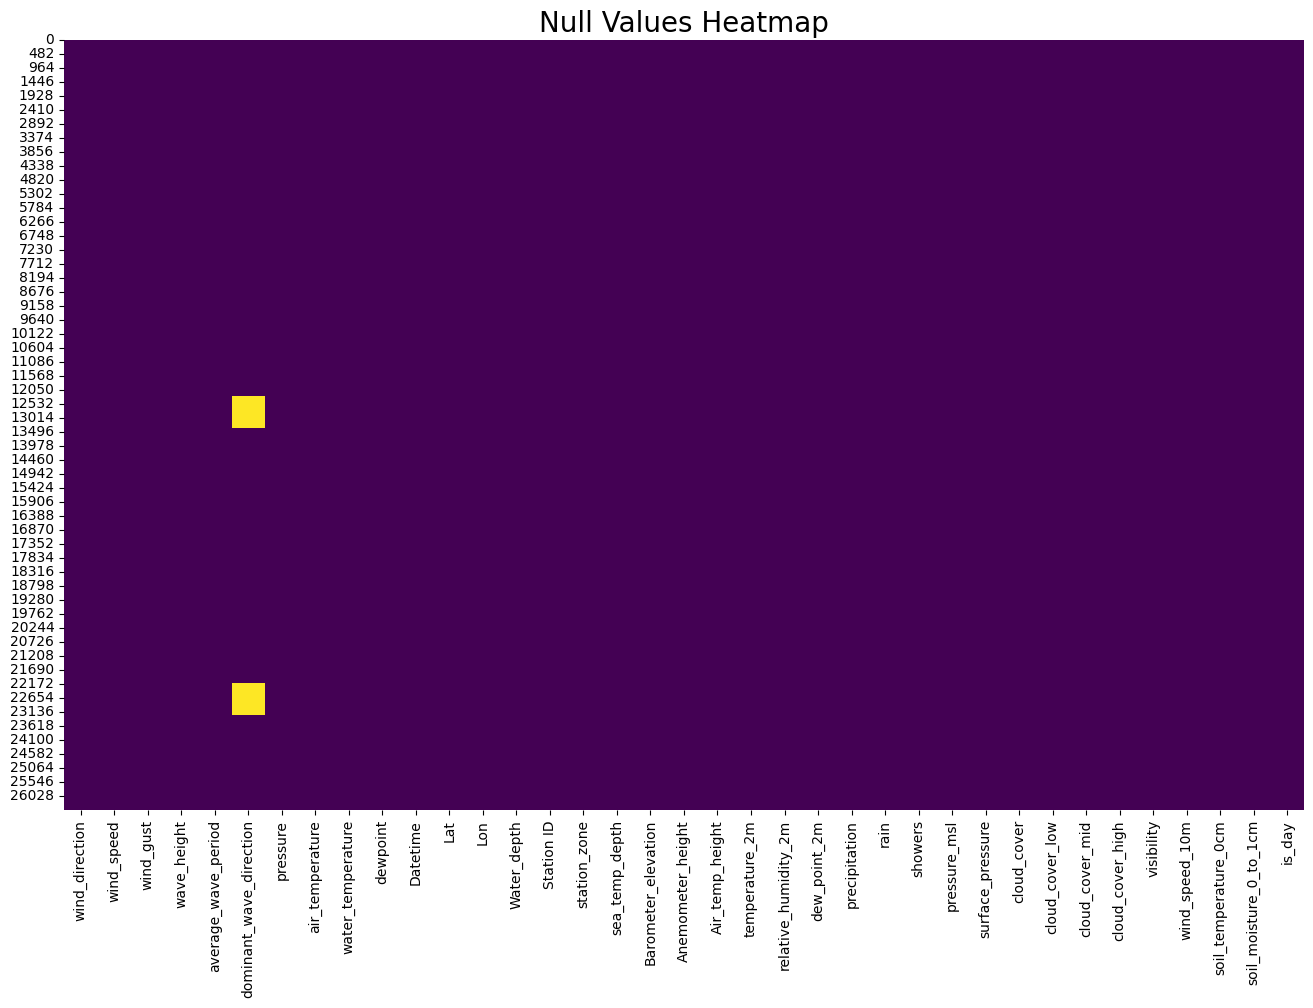

In [25]:
# null value heatmap with sns

plt.figure(figsize=(16, 10))

sns.heatmap(df_final.isnull(), cbar=False, cmap='viridis')

plt.title('Null Values Heatmap', fontdict={'size': 20})

plt.show()

In [26]:
df_final = handle_null_values(df_final)
display_row_values(df_final)


Tag: yellow - Nombre de lignes: 26509
Colonne 'wind_direction' non modifiée (0% de valeurs manquantes)
Colonne 'wind_speed' non modifiée (0% de valeurs manquantes)
Colonne 'wind_gust' non modifiée (0% de valeurs manquantes)
Colonne 'wave_height' non modifiée (0% de valeurs manquantes)
Colonne 'average_wave_period' non modifiée (0% de valeurs manquantes)
Colonne 'dominant_wave_direction' Imputée par la médiane (8.28% de valeurs manquantes)
Colonne 'pressure' non modifiée (0% de valeurs manquantes)
Colonne 'air_temperature' non modifiée (0% de valeurs manquantes)
Colonne 'water_temperature' non modifiée (0% de valeurs manquantes)
Colonne 'dewpoint' non modifiée (0% de valeurs manquantes)
Colonne 'Datetime' non modifiée (0% de valeurs manquantes)
Colonne 'Lat' non modifiée (0% de valeurs manquantes)
Colonne 'Lon' non modifiée (0% de valeurs manquantes)
Colonne 'Water_depth' non modifiée (0% de valeurs manquantes)
Colonne 'Station ID' non modifiée (0% de valeurs manquantes)
Colonne 'stati

Hour Filtering

In [27]:
try:
    df_final = df_final[['Datetime', 'Lat', 'Lon'] + [col for col in df_final.columns if col not in ['Datetime', 'Lat', 'Lon']]]
    # placer la colonne Datetime en %Y-%m-%d %H
    
    print(f"🚀 DataFrame filtrée pour ne garder que les lignes à l'heure pile: {df_final.shape[0]} lignes")

except Exception as e:
    print(str(e))
finally:
    display(df_final.columns)

🚀 DataFrame filtrée pour ne garder que les lignes à l'heure pile: 26509 lignes


Index(['Datetime', 'Lat', 'Lon', 'wind_direction', 'wind_speed', 'wind_gust',
       'wave_height', 'average_wave_period', 'dominant_wave_direction',
       'pressure', 'air_temperature', 'water_temperature', 'dewpoint',
       'Water_depth', 'Station ID', 'station_zone', 'sea_temp_depth',
       'Barometer_elevation', 'Anemometer_height', 'Air_temp_height',
       'temperature_2m', 'relative_humidity_2m', 'dew_point_2m',
       'precipitation', 'rain', 'showers', 'pressure_msl', 'surface_pressure',
       'cloud_cover', 'cloud_cover_low', 'cloud_cover_mid', 'cloud_cover_high',
       'visibility', 'wind_speed_10m', 'soil_temperature_0cm',
       'soil_moisture_0_to_1cm', 'is_day'],
      dtype='object')

In [28]:
df_final.columns = [col.strip() for col in df_final.columns]

Renaming and deleting useless columns

In [29]:
# Dictionnaire de renommage des colonnes
col_to_rename = {'temperature_2m': 'T°(C°)', 
                 'relative_humidity_2m': 'Relative Humidity (%)',
                 'dew_point_2m': 'Dew Point (°C)', 
                 'precipitation': 'Precipitations (mm)',  
                 'pressure_msl':'Sea Level Pressure (hPa)', 
                 'cloud_cover_low':'Low Clouds (%)',
                 'cloud_cover_mid' : 'Middle Clouds (%)', 
                 'cloud_cover_high' : 'High Clouds (%)', 
                 'visibility' : 'Visibility (km)', 
                 'wind_direction': 'Wind Direction (°)',
                 'wind_speed': 'Wind Speed (km/h)', 
                 'wind_gust': 'Wind Gusts (km/h)',
                 'wind_speed_10m':'Wind Speed (10m)', 
                 'surface_pressure': 'Surface Pressure',
                 'wave_height': 'Wave Height (m)', 
                 'average_wave_period': 'Average Wave Period (s)',
                 'dominant_wave_direction': 'Dominant Wave Direction (°)', 
                 'pressure': 'Pressure (hPa)',
                 'air_temperature': 'Air T°', 
                 'water_temperature': 'Water T°', 
                 'Water_depth': 'Water Depth (m)', 
                 "Air_temp_height": "Air T° Height", 
                 "Anemometer_height": "Anemometer Height (m)", 
                 "station_zone": "Station Zone",
                 "Barometer_elevation": "Barometer Elevation", 
                 "sea_temp_depth" : "Sea Temperature Depth (m)",
                 "cloud_cover": "Cloud Cover (%)"
                 }

# Liste des colonnes à supprimer
cols_to_delete = ['soil_temperature_0cm', 'lat_buoy','lon_buoy', 'rain', 
                  'showers', 'is_day', 'soil_moisture_0_to_1cm']
	
# Renommer les colonnes d'abord
df_final = rename_columns(df_final, col_to_rename)
# Ensuite, supprimer les colonnes non désirées
df_final = drop_columns_if_exist(df_final, cols_to_delete)
try:
    if df_final['Visibility (km)'].mean() > 1000:
        df_final['Visibility (km)'] = df_final['Visibility (km)'] / 1000
        print("Conversion de la visibilité de mètres à kilomètres")
    df_final["T°(C°)"] = round(df_final["T°(C°)"], 2)
    df_final["Wind Speed (10m)"] = round(df_final["Wind Speed (10m)"], 2)
except Exception as e:
    print(f"�� Erreur lors du traitement des colonnes :\n {e}")

# Afficher les résultats
print("\nColonnes après renommage et suppression :")
print("\n")
display_row_values(df_final)

🔄 Colonne 'temperature_2m' renommée en 'T°(C°)'
🔄 Colonne 'relative_humidity_2m' renommée en 'Relative Humidity (%)'
🔄 Colonne 'dew_point_2m' renommée en 'Dew Point (°C)'
🔄 Colonne 'precipitation' renommée en 'Precipitations (mm)'
🔄 Colonne 'pressure_msl' renommée en 'Sea Level Pressure (hPa)'
🔄 Colonne 'cloud_cover_low' renommée en 'Low Clouds (%)'
🔄 Colonne 'cloud_cover_mid' renommée en 'Middle Clouds (%)'
🔄 Colonne 'cloud_cover_high' renommée en 'High Clouds (%)'
🔄 Colonne 'visibility' renommée en 'Visibility (km)'
🔄 Colonne 'wind_direction' renommée en 'Wind Direction (°)'
🔄 Colonne 'wind_speed' renommée en 'Wind Speed (km/h)'
🔄 Colonne 'wind_gust' renommée en 'Wind Gusts (km/h)'
🔄 Colonne 'wind_speed_10m' renommée en 'Wind Speed (10m)'
🔄 Colonne 'surface_pressure' renommée en 'Surface Pressure'
🔄 Colonne 'wave_height' renommée en 'Wave Height (m)'
🔄 Colonne 'average_wave_period' renommée en 'Average Wave Period (s)'
🔄 Colonne 'dominant_wave_direction' renommée en 'Dominant Wave Di

Transformer les coordonnées en format float

In [30]:
try:

    df_final[['Lat', 'Lon']] = df_final.apply(
        lambda row: pd.Series(convert_coordinates(row['Lat'], row['Lon'])),
        axis=1
    )
except Exception as e:
    print(f"Erreur : {e}")
finally:
    display_row_values(df_final)

Index  |  Datetime             |  Lat    |  Lon      |  Wind Direction (°)  |  Wind Speed (km/h)  |  Wind Gusts (km/h)  |  Wave Height (m)  |  Average Wave Period (s)  |  Dominant Wave Direction (°)  |  Pressure (hPa)  |  Air T°              |  Water T°  |  dewpoint  |  Water Depth (m)  |  Station ID  |  Station Zone                              |  Sea Temperature Depth (m)  |  Barometer Elevation  |  Anemometer Height (m)  |  Air T° Height  |  T°(C°)  |  Relative Humidity (%)  |  Dew Point (°C)  |  Precipitations (mm)  |  Sea Level Pressure (hPa)  |  Surface Pressure  |  Cloud Cover (%)  |  Low Clouds (%)  |  Middle Clouds (%)  |  High Clouds (%)  |  Visibility (km)  |  Wind Speed (10m)
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Pressure and air temperatures are very close
We'll make the average of them all

In [31]:
try:
    df_final['T°(C°)'] = (df_final['Air T°'] + df_final['T°(C°)']) / 2
    df_final['T°(C°)'] = df_final['T°(C°)'].round(2)
    df_final.drop(columns=['Air T°'], inplace=True)
    
    df_final['Sea Level Pressure (hPa)'] = round((df_final['Sea Level Pressure (hPa)'] + df_final['Surface Pressure']) / 2, 2)
    df_final.drop(columns=['Surface Pressure'], inplace=True)
except Exception as e:
    print(f"Erreur :\n {e}")
    
display_row_values(df_final)

Index  |  Datetime             |  Lat    |  Lon      |  Wind Direction (°)  |  Wind Speed (km/h)  |  Wind Gusts (km/h)  |  Wave Height (m)  |  Average Wave Period (s)  |  Dominant Wave Direction (°)  |  Pressure (hPa)  |  Water T°  |  dewpoint  |  Water Depth (m)  |  Station ID  |  Station Zone                              |  Sea Temperature Depth (m)  |  Barometer Elevation  |  Anemometer Height (m)  |  Air T° Height  |  T°(C°)  |  Relative Humidity (%)  |  Dew Point (°C)  |  Precipitations (mm)  |  Sea Level Pressure (hPa)  |  Cloud Cover (%)  |  Low Clouds (%)  |  Middle Clouds (%)  |  High Clouds (%)  |  Visibility (km)  |  Wind Speed (10m)
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Create Categorical Time columns and delete the 'm' in Water Depth Column

In [32]:
try:
    # Créer une colonne temporaire pour accéder à .dt

    df_final['Year'] = df_final['Datetime'].dt.year.astype(str)
    df_final['Month'] = df_final['Datetime'].dt.month_name()
    df_final['Day'] = df_final['Datetime'].dt.day.astype(str)
    df_final['Hour'] = df_final['Datetime'].dt.hour.astype(str)
    df_final['DayOfWeek'] = df_final['Datetime'].dt.day_name()
    df_final['DayPeriod'] = df_final['Datetime'].apply(
        lambda x: 'Morning' if 6 <= x.hour < 12 else
                  'Afternoon' if 12 <= x.hour < 18 else
                  'Evening' if 18 <= x.hour < 22 else
                  'Night'
    )

except Exception as e:
    print(f"Erreur :\n {e}")

try:
    # virer le m dans Water Depth avec regex lambda et passer la colonne en float
    df_final['Water Depth (m)'] = df_final['Water Depth (m)'].apply(lambda x: re.sub(r'\D', '', str(x)).strip())
    df_final['Water Depth (m)'] = df_final['Water Depth (m)'].astype(float)
except Exception as e:
    print(str(e))

display_row_values(df_final)

Index  |  Datetime             |  Lat    |  Lon      |  Wind Direction (°)  |  Wind Speed (km/h)  |  Wind Gusts (km/h)  |  Wave Height (m)  |  Average Wave Period (s)  |  Dominant Wave Direction (°)  |  Pressure (hPa)  |  Water T°  |  dewpoint  |  Water Depth (m)  |  Station ID  |  Station Zone                              |  Sea Temperature Depth (m)  |  Barometer Elevation  |  Anemometer Height (m)  |  Air T° Height  |  T°(C°)  |  Relative Humidity (%)  |  Dew Point (°C)  |  Precipitations (mm)  |  Sea Level Pressure (hPa)  |  Cloud Cover (%)  |  Low Clouds (%)  |  Middle Clouds (%)  |  High Clouds (%)  |  Visibility (km)  |  Wind Speed (10m)  |  Year  |  Month  |  Day  |  Hour  |  DayOfWeek  |  DayPeriod
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [33]:
df_final.dtypes

Datetime                       datetime64[ns]
Lat                                   float64
Lon                                   float64
Wind Direction (°)                    float64
Wind Speed (km/h)                     float64
Wind Gusts (km/h)                     float64
Wave Height (m)                       float64
Average Wave Period (s)               float64
Dominant Wave Direction (°)           float64
Pressure (hPa)                        float64
Water T°                              float64
dewpoint                              float64
Water Depth (m)                       float64
Station ID                             object
Station Zone                           object
Sea Temperature Depth (m)              object
Barometer Elevation                    object
Anemometer Height (m)                  object
Air T° Height                          object
T°(C°)                                float64
Relative Humidity (%)                 float32
Dew Point (°C)                    

Check truth about Wind Speed Using another API call

In [34]:
df_42058 = df_final[df_final['Station ID'] == "42058"]
df_42058.columns

Index(['Datetime', 'Lat', 'Lon', 'Wind Direction (°)', 'Wind Speed (km/h)',
       'Wind Gusts (km/h)', 'Wave Height (m)', 'Average Wave Period (s)',
       'Dominant Wave Direction (°)', 'Pressure (hPa)', 'Water T°', 'dewpoint',
       'Water Depth (m)', 'Station ID', 'Station Zone',
       'Sea Temperature Depth (m)', 'Barometer Elevation',
       'Anemometer Height (m)', 'Air T° Height', 'T°(C°)',
       'Relative Humidity (%)', 'Dew Point (°C)', 'Precipitations (mm)',
       'Sea Level Pressure (hPa)', 'Cloud Cover (%)', 'Low Clouds (%)',
       'Middle Clouds (%)', 'High Clouds (%)', 'Visibility (km)',
       'Wind Speed (10m)', 'Year', 'Month', 'Day', 'Hour', 'DayOfWeek',
       'DayPeriod'],
      dtype='object')

Requête à l'API Visual Crossing pour les données de vérification (1 / 24h)

In [35]:
# ---- Chargement de la clé API ----
vc_api_key_path = r"c:\Credentials\visual_crossing_weather_api.json"
with open(vc_api_key_path, 'r') as file:
    content = json.load(file)
    vc_api_key = content["api_key"]

# ---- Extraire les coordonnées depuis la première ligne du DataFrame ----
lat_42058, lon_42058 = None, None

if not df_42058.empty:
    first_row = df_42058.iloc[0]
    lat_42058, lon_42058 = first_row["Lat"], first_row["Lon"]

# ---- Définir les dates pour la requête ----
today = datetime.now().strftime("%Y-%m-%d")
last_month = (datetime.now() - timedelta(days=31)).strftime("%Y-%m-%d")

# ---- Créer le dossier de cache si nécessaire ----
cache_dir = "api_call_files"
os.makedirs(cache_dir, exist_ok=True)

# ---- Définir le fichier cache selon la position ----
cache_file = os.path.join(cache_dir, f"vc_meteo_{lat_42058}_{lon_42058}.csv")

# ---- Vérifier si un cache récent existe (moins de 24h) ----
use_cache = False
if os.path.exists(cache_file):
    last_modified = datetime.fromtimestamp(os.path.getmtime(cache_file))
    if datetime.now() - last_modified < timedelta(hours=24):
        print(f"📦 Cache détecté ({cache_file}), modifié le {last_modified.strftime('%Y-%m-%d %H:%M:%S')}")
        vc_meteo_df = pd.read_csv(cache_file)
        print("✅ Données météo rechargées depuis le cache.")
        use_cache = True
    else:
        print(f"⚠️ Cache trouvé mais périmé (plus de 24h) → nouvelle requête API.")

# ---- Appel API si pas de cache valide ----
if not use_cache and lat_42058 is not None and lon_42058 is not None:
    url = f"https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/timeline/{lat_42058},{lon_42058}/{last_month}/{today}?unitGroup=metric&key={vc_api_key}&contentType=json"
    
    try:
        response = requests.get(url)
        if response.status_code == 200:
            vc_meteo_data = response.json()
            print("🌍 Données météo récupérées depuis l'API Visual Crossing.")

            # ---- Extraire les données journalières et sauvegarder ----
            if "days" in vc_meteo_data:
                vc_meteo_df = pd.json_normalize(vc_meteo_data["days"])
                vc_meteo_df.to_csv(cache_file, index=False)
                print(f"💾 Données sauvegardées dans le cache : {cache_file}")
            else:
                print("⚠️ Le champ 'days' est absent de la réponse API.")
        else:
            print(f"❌ Échec de l’appel API — code de statut : {response.status_code}")
    except Exception as e:
        print(f"❌ Exception levée lors de la requête API : {e}")
        

# 📁 Charger les données du CSV Visual Crossing
vc_csv_path = f"vc_api_call_files/vc_meteo_{lat_42058}_{lon_42058}.csv"
df_vc_meteo = pd.read_csv(vc_csv_path)
try:
    # mettre Datetime en index
    df_vc_meteo.rename(columns={"datetime": "Datetime"}, inplace=True)  
    
except Exception as e:
    print(f"Erreur :\n {e}")

df_vc_meteo.head()

❌ Échec de l’appel API — code de statut : 429


,Datetime,datetimeEpoch,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,...,sunriseEpoch,sunset,sunsetEpoch,moonphase,conditions,description,icon,stations,source,hours
0,2025-03-29,1743224400,27.7,27.1,27.4,31.1,29.7,30.6,23.7,80.2,...,1743245886,18:12:37,1743289957,0.00,"Rain, Partially cloudy",Partly cloudy throughout the day with early mo...,rain,"['42058_maritime', 'remote']",obs,"[{'datetime': '00:00:00', 'datetimeEpoch': 174..."
1,2025-03-30,1743310800,27.9,26.9,27.4,31.2,29.4,30.4,23.3,78.5,...,1743332244,18:12:43,1743376363,0.04,Rain,Clear conditions throughout the day with rain ...,rain,"['42058_maritime', 'remote']",obs,"[{'datetime': '00:00:00', 'datetimeEpoch': 174..."
2,2025-03-31,1743397200,27.8,25.9,27.3,31.1,25.9,30.2,23.4,79.4,...,1743418602,18:12:50,1743462770,0.08,"Rain, Partially cloudy",Partly cloudy throughout the day with a chance...,rain,"['42058_maritime', 'remote']",obs,"[{'datetime': '00:00:00', 'datetimeEpoch': 174..."
3,2025-04-01,1743483600,27.7,27.3,27.4,31.2,30.1,30.5,23.5,79.0,...,1743504960,18:12:56,1743549176,0.11,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,['42058_maritime'],obs,"[{'datetime': '00:00:00', 'datetimeEpoch': 174..."
4,2025-04-02,1743570000,27.9,26.7,27.6,31.7,26.7,30.7,23.7,79.4,...,1743591318,18:13:03,1743635583,0.15,"Rain, Partially cloudy",Becoming cloudy in the afternoon with rain cle...,rain,"['42058_maritime', 'remote']",obs,"[{'datetime': '00:00:00', 'datetimeEpoch': 174..."


# Nettoyage du DataFrame retourné

In [36]:
# 🧼 Nettoyage et transformation
all_hours = []

for i, row in df_vc_meteo.iterrows():
    try:
        hours_list = ast.literal_eval(row['hours'])

        for hour_data in hours_list:
            hour_data['Date'] = i  # ✅ On met l'index courant, i.e. la date du jour
            all_hours.append(hour_data)

    except Exception as e:
        print(f"Erreur parsing ligne {i}: {e}")

df_vc_flat = pd.DataFrame(all_hours)

# 🕒 Convertir le timestamp en datetime string
df_vc_flat["Datetime"] = pd.to_datetime(df_vc_flat["datetimeEpoch"], unit="s").dt.strftime("%Y-%m-%d-%H")

# 🗓️ Filtrer sur les 30 derniers jours
today = datetime.now()
thirty_days_ago = today - timedelta(days=30)

df_vc_flat['Date'] = pd.to_datetime(df_vc_flat['Date'])  # 👈 Assurer que c'est bien du datetime
df_vc_last_month = df_vc_flat[
    (df_vc_flat['Date'] >= thirty_days_ago) & 
    (df_vc_flat['Date'] <= today)
]


# Renommage des colonnes pour faciliter la comparaison

In [37]:
#Filtrer les colonnes nécessaires
try:
    df_vc_last_month = df_vc_last_month[["Datetime", "temp", "humidity", "precip", "dew", "windgust", 
                                     "windspeed", "winddir", "pressure", "visibility"]]
except Exception as e:
        print(f"Erreur lors du filtrage des colonnes:\n {e}\n")

try:
        df_vc_last_month["Datetime"] = pd.to_datetime(df_vc_last_month["Datetime"], errors='coerce')
except Exception as e:
        print(f"Erreur lors du reformatage de la colonne Datetime:\n {e}\n")        

for col in df_vc_last_month.columns:
        try:
            # 
            if not "Datetime" in col:
                if not col.startswith("VC_"):
                        rename_columns(df_vc_last_month, {col: f"VC_{col}"})
        except Exception as e:
                print(f"Erreur lors du renommage de la colonne {col}:\n {e}\n")


🔄 Colonne 'temp' renommée en 'VC_temp'
✅ Colonnes renommées : {'temp': 'VC_temp'}
🔄 Colonne 'humidity' renommée en 'VC_humidity'
✅ Colonnes renommées : {'humidity': 'VC_humidity'}
🔄 Colonne 'precip' renommée en 'VC_precip'
✅ Colonnes renommées : {'precip': 'VC_precip'}
🔄 Colonne 'dew' renommée en 'VC_dew'
✅ Colonnes renommées : {'dew': 'VC_dew'}
🔄 Colonne 'windgust' renommée en 'VC_windgust'
✅ Colonnes renommées : {'windgust': 'VC_windgust'}
🔄 Colonne 'windspeed' renommée en 'VC_windspeed'
✅ Colonnes renommées : {'windspeed': 'VC_windspeed'}
🔄 Colonne 'winddir' renommée en 'VC_winddir'
✅ Colonnes renommées : {'winddir': 'VC_winddir'}
🔄 Colonne 'pressure' renommée en 'VC_pressure'
✅ Colonnes renommées : {'pressure': 'VC_pressure'}
🔄 Colonne 'visibility' renommée en 'VC_visibility'
✅ Colonnes renommées : {'visibility': 'VC_visibility'}


Enforce Datetime Format

In [38]:
# Check if the Datetime column is correctly converted
print(df_42058["Datetime"].dtype)
print(df_vc_last_month["Datetime"].dtype)

datetime64[ns]
datetime64[ns]


Merge and Compare DataFrames

In [39]:
try:
    
    df_compare = pd.merge(df_42058, df_vc_last_month, on="Datetime", how="inner")
    display(df_compare.columns)
    
except Exception as e:
    print(e)

Index(['Datetime', 'Lat', 'Lon', 'Wind Direction (°)', 'Wind Speed (km/h)',
       'Wind Gusts (km/h)', 'Wave Height (m)', 'Average Wave Period (s)',
       'Dominant Wave Direction (°)', 'Pressure (hPa)', 'Water T°', 'dewpoint',
       'Water Depth (m)', 'Station ID', 'Station Zone',
       'Sea Temperature Depth (m)', 'Barometer Elevation',
       'Anemometer Height (m)', 'Air T° Height', 'T°(C°)',
       'Relative Humidity (%)', 'Dew Point (°C)', 'Precipitations (mm)',
       'Sea Level Pressure (hPa)', 'Cloud Cover (%)', 'Low Clouds (%)',
       'Middle Clouds (%)', 'High Clouds (%)', 'Visibility (km)',
       'Wind Speed (10m)', 'Year', 'Month', 'Day', 'Hour', 'DayOfWeek',
       'DayPeriod', 'VC_temp', 'VC_humidity', 'VC_precip', 'VC_dew',
       'VC_windgust', 'VC_windspeed', 'VC_winddir', 'VC_pressure',
       'VC_visibility'],
      dtype='object')

Comparaison Wind Speed

In [40]:
try:
    # Wind Speed Comparison
    df_windspeed_compare = df_compare[['Wind Speed (km/h)', 'Wind Speed (10m)','VC_windspeed']]
    #  Pressure Comparison
    df_pressure_compare = df_compare[['Sea Level Pressure (hPa)','Pressure (hPa)', 'VC_pressure']]
    # Dew Point Comparison
    df_dew_compare = df_compare[['dewpoint','Dew Point (°C)', 'VC_dew']]
except Exception as e:
    print(e)

df_windspeed_compare.head()

,Wind Speed (km/h),Wind Speed (10m),VC_windspeed


In [41]:
wind_col_to_delete = ['Wind Speed (km/h)', 'Anemometer Height (m)']
df_final = drop_columns_if_exist(df_final, wind_col_to_delete)
# Arrondir les valeurs de df_final

df_final = df_final.round(2)

 Nombre initial de colonnes: 36
Colonne 'Wind Speed (km/h)' Supprimée
Colonne 'Anemometer Height (m)' Supprimée
 Nombre final de colonnes: 34


Comparaison Pressure

In [42]:
df_pressure_compare.head()

,Sea Level Pressure (hPa),Pressure (hPa),VC_pressure


In [43]:
df_final = drop_columns_if_exist(df_final, ['Pressure (hPa)'])

 Nombre initial de colonnes: 34
Colonne 'Pressure (hPa)' Supprimée
 Nombre final de colonnes: 33


In [44]:
df_dew_compare.head()

,dewpoint,Dew Point (°C),VC_dew


In [45]:
try:
    df_final['Dew Point (°C)'] = df_final['dewpoint']
    df_final = drop_columns_if_exist(df_final, ['dewpoint'])
    
except Exception as e:
    print(e)
display_row_values(df_final)

 Nombre initial de colonnes: 33
Colonne 'dewpoint' Supprimée
 Nombre final de colonnes: 32
Index  |  Datetime             |  Lat    |  Lon      |  Wind Direction (°)  |  Wind Gusts (km/h)  |  Wave Height (m)  |  Average Wave Period (s)  |  Dominant Wave Direction (°)  |  Water T°  |  Water Depth (m)  |  Station ID  |  Station Zone                              |  Sea Temperature Depth (m)  |  Barometer Elevation  |  Air T° Height  |  T°(C°)  |  Relative Humidity (%)  |  Dew Point (°C)  |  Precipitations (mm)  |  Sea Level Pressure (hPa)  |  Cloud Cover (%)  |  Low Clouds (%)  |  Middle Clouds (%)  |  High Clouds (%)  |  Visibility (km)  |  Wind Speed (10m)  |  Year  |  Month  |  Day  |  Hour  |  DayOfWeek  |  DayPeriod
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Rename Final Columns

In [46]:
try:
    df_final.rename(columns={'Air T° Height': 'Air T° Height (m)',
                             'Barometer Elevation': 'Barometer Elevation (m)',
                             'Water T°': 'Water T° (°C)'}, inplace=True)

    print("Column 'Air T° Height' renamed to 'Air T° Height (m)'")

    print("Column 'Barometer Elevation' renamed to 'Barometer Elevation (m)'")
    print("Column 'Water T°' renamed to 'Water T° (°C)'")
    df_final['T°(C°)'] = df_final['T°(C°)'].round(2)

    print("Column 'T°(C°)' rounded to 2 decimal places")
except Exception as e:
    print(e)
    
display_row_values(df_final)

Column 'Air T° Height' renamed to 'Air T° Height (m)'
Column 'Barometer Elevation' renamed to 'Barometer Elevation (m)'
Column 'Water T°' renamed to 'Water T° (°C)'
Column 'T°(C°)' rounded to 2 decimal places
Index  |  Datetime             |  Lat    |  Lon      |  Wind Direction (°)  |  Wind Gusts (km/h)  |  Wave Height (m)  |  Average Wave Period (s)  |  Dominant Wave Direction (°)  |  Water T° (°C)  |  Water Depth (m)  |  Station ID  |  Station Zone                              |  Sea Temperature Depth (m)  |  Barometer Elevation (m)  |  Air T° Height (m)  |  T°(C°)  |  Relative Humidity (%)  |  Dew Point (°C)  |  Precipitations (mm)  |  Sea Level Pressure (hPa)  |  Cloud Cover (%)  |  Low Clouds (%)  |  Middle Clouds (%)  |  High Clouds (%)  |  Visibility (km)  |  Wind Speed (10m)  |  Year  |  Month  |  Day  |  Hour  |  DayOfWeek  |  DayPeriod
---------------------------------------------------------------------------------------------------------------------------------------------

In [47]:
df_final.dtypes

Datetime                       datetime64[ns]
Lat                                   float64
Lon                                   float64
Wind Direction (°)                    float64
Wind Gusts (km/h)                     float64
Wave Height (m)                       float64
Average Wave Period (s)               float64
Dominant Wave Direction (°)           float64
Water T° (°C)                         float64
Water Depth (m)                       float64
Station ID                             object
Station Zone                           object
Sea Temperature Depth (m)              object
Barometer Elevation (m)                object
Air T° Height (m)                      object
T°(C°)                                float64
Relative Humidity (%)                 float32
Dew Point (°C)                        float64
Precipitations (mm)                   float32
Sea Level Pressure (hPa)              float32
Cloud Cover (%)                       float32
Low Clouds (%)                    

In [48]:
# Correction des types des colonnes
try:
    df_final['Lat'] = df_final['Lat'].astype(str)
    df_final['Lon'] = df_final['Lon'].astype(str)
    print(df_final.dtypes)
except Exception as e:
    print(e)

Datetime                       datetime64[ns]
Lat                                    object
Lon                                    object
Wind Direction (°)                    float64
Wind Gusts (km/h)                     float64
Wave Height (m)                       float64
Average Wave Period (s)               float64
Dominant Wave Direction (°)           float64
Water T° (°C)                         float64
Water Depth (m)                       float64
Station ID                             object
Station Zone                           object
Sea Temperature Depth (m)              object
Barometer Elevation (m)                object
Air T° Height (m)                      object
T°(C°)                                float64
Relative Humidity (%)                 float32
Dew Point (°C)                        float64
Precipitations (mm)                   float32
Sea Level Pressure (hPa)              float32
Cloud Cover (%)                       float32
Low Clouds (%)                    

In [49]:
display_row_values(df_final)

Index  |  Datetime             |  Lat    |  Lon      |  Wind Direction (°)  |  Wind Gusts (km/h)  |  Wave Height (m)  |  Average Wave Period (s)  |  Dominant Wave Direction (°)  |  Water T° (°C)  |  Water Depth (m)  |  Station ID  |  Station Zone                              |  Sea Temperature Depth (m)  |  Barometer Elevation (m)  |  Air T° Height (m)  |  T°(C°)  |  Relative Humidity (%)  |  Dew Point (°C)  |  Precipitations (mm)  |  Sea Level Pressure (hPa)  |  Cloud Cover (%)  |  Low Clouds (%)  |  Middle Clouds (%)  |  High Clouds (%)  |  Visibility (km)  |  Wind Speed (10m)  |  Year  |  Month  |  Day  |  Hour  |  DayOfWeek  |  DayPeriod
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [50]:
df_final.columns

Index(['Datetime', 'Lat', 'Lon', 'Wind Direction (°)', 'Wind Gusts (km/h)',
       'Wave Height (m)', 'Average Wave Period (s)',
       'Dominant Wave Direction (°)', 'Water T° (°C)', 'Water Depth (m)',
       'Station ID', 'Station Zone', 'Sea Temperature Depth (m)',
       'Barometer Elevation (m)', 'Air T° Height (m)', 'T°(C°)',
       'Relative Humidity (%)', 'Dew Point (°C)', 'Precipitations (mm)',
       'Sea Level Pressure (hPa)', 'Cloud Cover (%)', 'Low Clouds (%)',
       'Middle Clouds (%)', 'High Clouds (%)', 'Visibility (km)',
       'Wind Speed (10m)', 'Year', 'Month', 'Day', 'Hour', 'DayOfWeek',
       'DayPeriod'],
      dtype='object')

In [51]:
df_marine_cleaned = df_final[['Datetime', 'Lat', 'Lon',
       'Wave Height (m)', 'Average Wave Period (s)',
       'Dominant Wave Direction (°)', 'Water T° (°C)', 'Water Depth (m)',
       'Station ID', 'Station Zone', 'Sea Temperature Depth (m)',
       'Barometer Elevation (m)', 
       'Sea Level Pressure (hPa)', 'Year', 'Month', 'Day', 'Hour', 'DayOfWeek',
       'DayPeriod']]
df_meteo_cleaned = df_final[['Datetime', 'Lat', 'Lon', 
                             'Wind Direction (°)', 'Wind Gusts (km/h)',
       'Station ID', 'Station Zone', 'Sea Temperature Depth (m)',
       'Barometer Elevation (m)', 'Air T° Height (m)', 'T°(C°)',

       'Relative Humidity (%)', 'Dew Point (°C)', 'Precipitations (mm)',
       'Cloud Cover (%)', 'Low Clouds (%)',
       'Middle Clouds (%)', 'High Clouds (%)', 'Visibility (km)',
       'Wind Speed (10m)', 'Year', 'Month', 'Day', 'Hour', 'DayOfWeek',
       'DayPeriod']]

print(f"DataFrame Marine Index: {df_marine_cleaned.index}")
print(f"DataFrame Meteo Index: {df_meteo_cleaned.index}")

DataFrame Marine Index: RangeIndex(start=0, stop=26509, step=1)
DataFrame Meteo Index: RangeIndex(start=0, stop=26509, step=1)


In [52]:
marine_table_name = f"cleaned_marine_data"
create_table_in_mysql(table_name=table_staging_marine_name, 
                      engine=engine_staging, 
            df=df_marine_cleaned)

insert_new_rows(table_name=table_staging_marine_name, 
                engine=engine_staging, 
        df=df_marine_cleaned, ref= 'Datetime')



meteo_table_name = f"cleaned_meteo_data"
create_table_in_mysql(table_name= table_staging_meteo_name, 
        engine=engine_staging, df=df_meteo_cleaned)

insert_new_rows(table_name=table_staging_meteo_name, 
                engine=engine_staging, 
                df=df_meteo_cleaned, ref= 'Datetime')


🔄 Vérification de l'existence de la table...
⚠️ La table 'cleaned_marine_data' existe déjà.
🔎 0 valeurs déjà présentes dans la colonne 'Datetime'.
🚀 Insertion de 26509 lignes dans 'cleaned_marine_data'...
✅ Insertion terminée avec succès.
🔄 Vérification de l'existence de la table...
⚠️ La table 'cleaned_meteo_data' existe déjà.
🔎 1099 valeurs déjà présentes dans la colonne 'Datetime'.
⚠️ Aucune nouvelle ligne à insérer.


In [53]:
csv_folder = 'csv'
base_filename = "Cleaned_Data_Ocean_Meteo_ETL"

# Vérifier dans le dossier si de tels fichiers existent déjà avec ce nom de base
existing_files = os.listdir(csv_folder)

# Filtrer ceux qui commencent par le nom de base et ont l'extension .csv
matching_files = [f for f in existing_files if f.startswith(base_filename) and f.endswith('.csv')]

if len(matching_files) > 0:
    # Créer une liste vide pour stocker les DataFrames
    dfs = []

    # Lire chaque fichier CSV et ajouter la DataFrame à la liste
    for file in matching_files:
        file_path = os.path.join(csv_folder, file)
        df = pd.read_csv(file_path)
        dfs.append(df)

    # Concaténer toutes les DataFrames en une seule
    df_concat_existing_files = pd.concat(dfs, ignore_index=True)
    
    # Concaténer les données existantes avec df_final
    concatenated_df = pd.concat([df_concat_existing_files, df_final], ignore_index=True)
    
    # Supprimer les doublons basés sur la colonne 'Datetime'
    concatenated_df = concatenated_df.drop_duplicates(subset='Datetime', keep='last')
    concatenated_df['Datetime'] = pd.to_datetime(concatenated_df['Datetime'], errors='coerce')

    # Sauvegarder le CSV concaténé sans doublons
    save_concat_csv(concatenated_df, csv_folder=csv_folder, base_filename="Cleaned_Data_Ocean_Meteo_ETL")
    
    # Supprimer les fichiers CSV d'ingrédients
    for file in matching_files:
        os.remove(os.path.join(csv_folder, file))
else:
    # Si aucun fichier existant, juste sauvegarder df_final
    save_concat_csv(df_final, csv_folder=csv_folder, base_filename="Cleaned_Data_Ocean_Meteo_ETL")


In [54]:
display_row_values(df_final)

Index  |  Datetime             |  Lat    |  Lon      |  Wind Direction (°)  |  Wind Gusts (km/h)  |  Wave Height (m)  |  Average Wave Period (s)  |  Dominant Wave Direction (°)  |  Water T° (°C)  |  Water Depth (m)  |  Station ID  |  Station Zone                              |  Sea Temperature Depth (m)  |  Barometer Elevation (m)  |  Air T° Height (m)  |  T°(C°)  |  Relative Humidity (%)  |  Dew Point (°C)  |  Precipitations (mm)  |  Sea Level Pressure (hPa)  |  Cloud Cover (%)  |  Low Clouds (%)  |  Middle Clouds (%)  |  High Clouds (%)  |  Visibility (km)  |  Wind Speed (10m)  |  Year  |  Month  |  Day  |  Hour  |  DayOfWeek  |  DayPeriod
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Création des DataFrames pour les tables du DW

In [55]:
# Colonnes dérivées
df_finalfor_DW = df_final.copy()
df_finalfor_DW['Date ID'] = df_final['Datetime'].dt.strftime('%Y%m%d%H')
df_finalfor_DW['Unique ID'] = df_final['Datetime'].dt.strftime('%Y%m%d%H%M') + df_final['Station ID']

In [56]:
#imprimer toutes les colonnes numeriquesq
num_cols = df_finalfor_DW.select_dtypes(include=[np.number]).columns

#imprimer toutes les colonnes non-numeriques
non_num_cols = df_finalfor_DW.select_dtypes(exclude=[np.number]).columns
non_num_cols

Index(['Datetime', 'Lat', 'Lon', 'Station ID', 'Station Zone',
       'Sea Temperature Depth (m)', 'Barometer Elevation (m)',
       'Air T° Height (m)', 'Year', 'Month', 'Day', 'Hour', 'DayOfWeek',
       'DayPeriod', 'Date ID', 'Unique ID'],
      dtype='object')

In [57]:
display_row_values(df_finalfor_DW)

Index  |  Datetime             |  Lat    |  Lon      |  Wind Direction (°)  |  Wind Gusts (km/h)  |  Wave Height (m)  |  Average Wave Period (s)  |  Dominant Wave Direction (°)  |  Water T° (°C)  |  Water Depth (m)  |  Station ID  |  Station Zone                              |  Sea Temperature Depth (m)  |  Barometer Elevation (m)  |  Air T° Height (m)  |  T°(C°)  |  Relative Humidity (%)  |  Dew Point (°C)  |  Precipitations (mm)  |  Sea Level Pressure (hPa)  |  Cloud Cover (%)  |  Low Clouds (%)  |  Middle Clouds (%)  |  High Clouds (%)  |  Visibility (km)  |  Wind Speed (10m)  |  Year  |  Month  |  Day  |  Hour  |  DayOfWeek  |  DayPeriod  |  Date ID     |  Unique ID        
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [58]:
##################################### DimStation ##################################################################################################

df_station = df_finalfor_DW[[
    'Station ID', 'Station Zone', 'Lat', 'Lon'
]].copy().drop_duplicates()

###################################### DimTime ##################################################################################################

df_time = df_finalfor_DW[['Datetime', 'Year', 'Month', 'DayOfWeek', 'Day', 'Hour', 'DayPeriod']].copy().drop_duplicates()

########################################## Facts Meteo #########################################################################

df_facts_meteo = df_finalfor_DW[[
    'Unique ID', # PK
    'T°(C°)', 'Relative Humidity (%)', 'Dew Point (°C)', 'Precipitations (mm)',
    'Sea Level Pressure (hPa)', 'Low Clouds (%)', 'Middle Clouds (%)', 'High Clouds (%)',
    "Cloud Cover (%)", 'Visibility (km)', 'Wind Speed (10m)', 'Wind Direction (°)',
    'Wind Gusts (km/h)', 'Barometer Elevation (m)', 'Air T° Height (m)',
    
    'Station ID', # FK
    'Datetime' # FK
]].copy().drop_duplicates()

########################################## Facts Ocean #########################################################################

df_facts_ocean = df_finalfor_DW[[
    'Unique ID', # PK
    'Wave Height (m)', 'Average Wave Period (s)', 'Dominant Wave Direction (°)',
    'Water T° (°C)', 'Water Depth (m)', 'Sea Temperature Depth (m)',
    
    'Station ID', # FK
    'Datetime'  # FK
]].copy().drop_duplicates()


In [59]:
display_row_values(df_time)

Index  |  Datetime             |  Year  |  Month  |  DayOfWeek  |  Day  |  Hour  |  DayPeriod
--------------------------------------------------------------------------------------
0      |  2025-04-29 18:00:00  |  2025  |  April  |  Tuesday    |  29   |  18    |  Evening  
1      |  2025-04-29 17:00:00  |  2025  |  April  |  Tuesday    |  29   |  17    |  Afternoon
2      |  2025-04-29 16:00:00  |  2025  |  April  |  Tuesday    |  29   |  16    |  Afternoon
3      |  2025-04-29 15:00:00  |  2025  |  April  |  Tuesday    |  29   |  15    |  Afternoon
4      |  2025-04-29 14:00:00  |  2025  |  April  |  Tuesday    |  29   |  14    |  Afternoon
5      |  2025-04-29 13:00:00  |  2025  |  April  |  Tuesday    |  29   |  13    |  Afternoon
6      |  2025-04-29 12:00:00  |  2025  |  April  |  Tuesday    |  29   |  12    |  Afternoon
7      |  2025-04-29 11:00:00  |  2025  |  April  |  Tuesday    |  29   |  11    |  Morning  
8      |  2025-04-29 10:00:00  |  2025  |  April  |  Tuesday    |  

In [60]:
display_row_values(df_station)

Index  |  Station ID  |  Station Zone                              |  Lat    |  Lon    
-----------------------------------------------------------------------------------
0      |  41004       |  edisto                                    |  32.5   |  -79.1  
1092   |  41008       |  grays reef                                |  31.4   |  -80.87 
2190   |  41044       |  ne st martin                              |  21.58  |  -58.63 
3280   |  41046       |  east bahamas                              |  23.86  |  -68.34 
3466   |  41049       |  south bermuda                             |  27.5   |  -62.27 
4564   |  42001       |  mid gulf                                  |  25.93  |  -89.66 
5661   |  42002       |  west gulf                                 |  25.95  |  -93.78 
6756   |  42020       |  corpus christi, tx                        |  26.97  |  -96.68 
7854   |  42036       |  west tampa                                |  28.5   |  -84.5  
8951   |  42056       |  yucatan bas

In [61]:
display_row_values(df_facts_meteo)

Index  |  Unique ID          |  T°(C°)  |  Relative Humidity (%)  |  Dew Point (°C)  |  Precipitations (mm)  |  Sea Level Pressure (hPa)  |  Low Clouds (%)  |  Middle Clouds (%)  |  High Clouds (%)  |  Cloud Cover (%)  |  Visibility (km)  |  Wind Speed (10m)  |  Wind Direction (°)  |  Wind Gusts (km/h)  |  Barometer Elevation (m)  |  Air T° Height (m)  |  Station ID  |  Datetime           
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
0      |  20250429180041004  |  21.73   |  67.0                   |  13.4            |  0.0                  |  1024.3                    |  0.0             |  0.0                |  0.0              |  0.0              |  26.4      

In [62]:
display_row_values(df_facts_ocean)

Index  |  Unique ID          |  Wave Height (m)  |  Average Wave Period (s)  |  Dominant Wave Direction (°)  |  Water T° (°C)  |  Water Depth (m)  |  Sea Temperature Depth (m)  |  Station ID  |  Datetime           
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
0      |  20250429180041004  |  1.1              |  5.1                      |  128.0                        |  22.2           |  35.0             |  1.5                        |  41004       |  2025-04-29 18:00:00
1      |  20250429170041004  |  1.1              |  5.1                      |  128.0                        |  22.2           |  35.0             |  1.5                        |  41004       |  2025-04-29 17:00:00
2      |  20250429160041004  |  1.1              |  5.1                      |  128.0                        |  22.1           |  35.0             | 

In [63]:
# Vérifier les doublons
print(f"Doublons dans df_station : {df_station.duplicated().sum()}")
print(f"Doublons dans df_time : {df_time.duplicated().sum()}")
print(f"Doublons dans df_facts_meteo : {df_facts_meteo.duplicated().sum()}")
print(f"Doublons dans df_facts_ocean : {df_facts_ocean.duplicated().sum()}")


Doublons dans df_station : 0
Doublons dans df_time : 0
Doublons dans df_facts_meteo : 0
Doublons dans df_facts_ocean : 0


Checking dim_station DataFrame

In [64]:
# check unique values
print(f"{df_station.shape[0]}\n\n{df_station.nunique()}")
display_row_values(df_station)

25

Station ID      25
Station Zone    25
Lat             24
Lon             25
dtype: int64
Index  |  Station ID  |  Station Zone                              |  Lat    |  Lon    
-----------------------------------------------------------------------------------
0      |  41004       |  edisto                                    |  32.5   |  -79.1  
1092   |  41008       |  grays reef                                |  31.4   |  -80.87 
2190   |  41044       |  ne st martin                              |  21.58  |  -58.63 
3280   |  41046       |  east bahamas                              |  23.86  |  -68.34 
3466   |  41049       |  south bermuda                             |  27.5   |  -62.27 
4564   |  42001       |  mid gulf                                  |  25.93  |  -89.66 
5661   |  42002       |  west gulf                                 |  25.95  |  -93.78 
6756   |  42020       |  corpus christi, tx                        |  26.97  |  -96.68 
7854   |  42036       |  west t

Création de la table dim_station et insertion des données

In [65]:
try:
    create_table_in_mysql(df=df_station, engine=engine_DW, table_name=table_dim_station_name)
    insert_new_rows(df=df_station, engine=engine_DW, table_name=table_dim_station_name, ref='Station ID')

except Exception as e:
    print(e)

🔄 Vérification de l'existence de la table...
✅ La table n'existe pas. Création de la table en cours...
🔑 Ajout de la colonne d'index 'index' comme clé primaire...
🔢 Colonne 'index' ajoutée en tant que '<class 'sqlalchemy.sql.sqltypes.Integer'>' (clé primaire)

🔄 Ajout des colonnes du DataFrame...
🔤 Colonne 'Station ID' ajoutée en tant que 'VARCHAR(255)'
🔤 Colonne 'Station Zone' ajoutée en tant que 'VARCHAR(255)'
🔤 Colonne 'Lat' ajoutée en tant que 'VARCHAR(255)'
🔤 Colonne 'Lon' ajoutée en tant que 'VARCHAR(255)'

🚀 Création de la table dans la base de données...

✅ Table 'dim_station' créée avec succès dans la base de données MySQL.
🔎 0 valeurs déjà présentes dans la colonne 'Station ID'.
🚀 Insertion de 25 lignes dans 'dim_station'...
✅ Insertion terminée avec succès.


Checking dim_time DataFrame

In [66]:
print(f"{df_time.shape[0]}\n\n{df_time.nunique()}")
display_row_values(df_time)

1099

Datetime     1099
Year            1
Month           2
DayOfWeek       7
Day            31
Hour           24
DayPeriod       4
dtype: int64
Index  |  Datetime             |  Year  |  Month  |  DayOfWeek  |  Day  |  Hour  |  DayPeriod
--------------------------------------------------------------------------------------
0      |  2025-04-29 18:00:00  |  2025  |  April  |  Tuesday    |  29   |  18    |  Evening  
1      |  2025-04-29 17:00:00  |  2025  |  April  |  Tuesday    |  29   |  17    |  Afternoon
2      |  2025-04-29 16:00:00  |  2025  |  April  |  Tuesday    |  29   |  16    |  Afternoon
3      |  2025-04-29 15:00:00  |  2025  |  April  |  Tuesday    |  29   |  15    |  Afternoon
4      |  2025-04-29 14:00:00  |  2025  |  April  |  Tuesday    |  29   |  14    |  Afternoon
5      |  2025-04-29 13:00:00  |  2025  |  April  |  Tuesday    |  29   |  13    |  Afternoon
6      |  2025-04-29 12:00:00  |  2025  |  April  |  Tuesday    |  29   |  12    |  Afternoon
7      |  2025-0

Création de la table dim_time et insertion des données

In [67]:
try:
    create_table_in_mysql(df=df_time, engine=engine_DW, table_name=table_dim_time_name)
    insert_new_rows(df=df_time, engine=engine_DW, table_name=table_dim_time_name, ref='Datetime')

except Exception as e:
    print(e)

🔄 Vérification de l'existence de la table...
✅ La table n'existe pas. Création de la table en cours...
🔑 Ajout de la colonne d'index 'index' comme clé primaire...
🔢 Colonne 'index' ajoutée en tant que '<class 'sqlalchemy.sql.sqltypes.Integer'>' (clé primaire)

🔄 Ajout des colonnes du DataFrame...
📅 Colonne 'Datetime' ajoutée en tant que '<class 'sqlalchemy.sql.sqltypes.DateTime'>'
🔤 Colonne 'Year' ajoutée en tant que 'VARCHAR(255)'
🔤 Colonne 'Month' ajoutée en tant que 'VARCHAR(255)'
🔤 Colonne 'DayOfWeek' ajoutée en tant que 'VARCHAR(255)'
🔤 Colonne 'Day' ajoutée en tant que 'VARCHAR(255)'
🔤 Colonne 'Hour' ajoutée en tant que 'VARCHAR(255)'
🔤 Colonne 'DayPeriod' ajoutée en tant que 'VARCHAR(255)'

🚀 Création de la table dans la base de données...

✅ Table 'dim_time' créée avec succès dans la base de données MySQL.
🔎 0 valeurs déjà présentes dans la colonne 'Datetime'.
🚀 Insertion de 1099 lignes dans 'dim_time'...
✅ Insertion terminée avec succès.


Checking Meteo Facts DataFrame

In [68]:
print(f"{df_facts_meteo.shape[0]}\n\n{df_facts_meteo.nunique()}")
display_row_values(df_facts_meteo)

26509

Unique ID                   26509
T°(C°)                       1700
Relative Humidity (%)          73
Dew Point (°C)                364
Precipitations (mm)            72
Sea Level Pressure (hPa)      560
Low Clouds (%)                101
Middle Clouds (%)             101
High Clouds (%)               101
Cloud Cover (%)               101
Visibility (km)              1221
Wind Speed (10m)             3354
Wind Direction (°)             36
Wind Gusts (km/h)              24
Barometer Elevation (m)         3
Air T° Height (m)               3
Station ID                     25
Datetime                     1099
dtype: int64
Index  |  Unique ID          |  T°(C°)  |  Relative Humidity (%)  |  Dew Point (°C)  |  Precipitations (mm)  |  Sea Level Pressure (hPa)  |  Low Clouds (%)  |  Middle Clouds (%)  |  High Clouds (%)  |  Cloud Cover (%)  |  Visibility (km)  |  Wind Speed (10m)  |  Wind Direction (°)  |  Wind Gusts (km/h)  |  Barometer Elevation (m)  |  Air T° Height (m)  |  Station ID

Création de la table facts_meteo et insertion des données

In [69]:
try:
    create_table_in_mysql(df=df_facts_meteo, engine=engine_DW, table_name=table_facts_meteo_name)
    insert_new_rows(df=df_facts_meteo, engine=engine_DW, table_name=table_facts_meteo_name, ref='Datetime')


except Exception as e:
    print(e)

🔄 Vérification de l'existence de la table...
✅ La table n'existe pas. Création de la table en cours...

🔄 Ajout des colonnes du DataFrame...
🔤 Colonne 'Unique ID' ajoutée en tant que 'VARCHAR(255)'
🔢 Colonne 'T°(C°)' ajoutée en tant que '<class 'sqlalchemy.sql.sqltypes.Float'>'
🔢 Colonne 'Relative Humidity (%)' ajoutée en tant que '<class 'sqlalchemy.sql.sqltypes.Float'>'
🔢 Colonne 'Dew Point (°C)' ajoutée en tant que '<class 'sqlalchemy.sql.sqltypes.Float'>'
🔢 Colonne 'Precipitations (mm)' ajoutée en tant que '<class 'sqlalchemy.sql.sqltypes.Float'>'
🔢 Colonne 'Sea Level Pressure (hPa)' ajoutée en tant que '<class 'sqlalchemy.sql.sqltypes.Float'>'
🔢 Colonne 'Low Clouds (%)' ajoutée en tant que '<class 'sqlalchemy.sql.sqltypes.Float'>'
🔢 Colonne 'Middle Clouds (%)' ajoutée en tant que '<class 'sqlalchemy.sql.sqltypes.Float'>'
🔢 Colonne 'High Clouds (%)' ajoutée en tant que '<class 'sqlalchemy.sql.sqltypes.Float'>'
🔢 Colonne 'Cloud Cover (%)' ajoutée en tant que '<class 'sqlalchemy.sql.

Checking Ocean Facts DataFrame

In [70]:
df_finalfor_DW.columns

Index(['Datetime', 'Lat', 'Lon', 'Wind Direction (°)', 'Wind Gusts (km/h)',
       'Wave Height (m)', 'Average Wave Period (s)',
       'Dominant Wave Direction (°)', 'Water T° (°C)', 'Water Depth (m)',
       'Station ID', 'Station Zone', 'Sea Temperature Depth (m)',
       'Barometer Elevation (m)', 'Air T° Height (m)', 'T°(C°)',
       'Relative Humidity (%)', 'Dew Point (°C)', 'Precipitations (mm)',
       'Sea Level Pressure (hPa)', 'Cloud Cover (%)', 'Low Clouds (%)',
       'Middle Clouds (%)', 'High Clouds (%)', 'Visibility (km)',
       'Wind Speed (10m)', 'Year', 'Month', 'Day', 'Hour', 'DayOfWeek',
       'DayPeriod', 'Date ID', 'Unique ID'],
      dtype='object')

In [71]:
print(f"{df_facts_ocean.shape[0]}\n\n{df_facts_ocean.nunique()}")
display_row_values(df_facts_ocean)

26509

Unique ID                      26509
Wave Height (m)                   38
Average Wave Period (s)           57
Dominant Wave Direction (°)      179
Water T° (°C)                    250
Water Depth (m)                   25
Sea Temperature Depth (m)          3
Station ID                        25
Datetime                        1099
dtype: int64
Index  |  Unique ID          |  Wave Height (m)  |  Average Wave Period (s)  |  Dominant Wave Direction (°)  |  Water T° (°C)  |  Water Depth (m)  |  Sea Temperature Depth (m)  |  Station ID  |  Datetime           
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
0      |  20250429180041004  |  1.1              |  5.1                      |  128.0                        |  22.2           |  35.0             |  1.5                        |  41004       |  2025-04-29 18:00:00
1      |  2

Création de la table facts_ocean et insertion des données

In [72]:
try:
    create_table_in_mysql(df=df_facts_ocean, engine=engine_DW, table_name=table_facts_marine_name)
    insert_new_rows(df=df_facts_ocean, engine=engine_DW, table_name=table_facts_marine_name, ref='Datetime')

except Exception as e:
    print(e)

🔄 Vérification de l'existence de la table...
✅ La table n'existe pas. Création de la table en cours...

🔄 Ajout des colonnes du DataFrame...
🔤 Colonne 'Unique ID' ajoutée en tant que 'VARCHAR(255)'
🔢 Colonne 'Wave Height (m)' ajoutée en tant que '<class 'sqlalchemy.sql.sqltypes.Float'>'
🔢 Colonne 'Average Wave Period (s)' ajoutée en tant que '<class 'sqlalchemy.sql.sqltypes.Float'>'
🔢 Colonne 'Dominant Wave Direction (°)' ajoutée en tant que '<class 'sqlalchemy.sql.sqltypes.Float'>'
🔢 Colonne 'Water T° (°C)' ajoutée en tant que '<class 'sqlalchemy.sql.sqltypes.Float'>'
🔢 Colonne 'Water Depth (m)' ajoutée en tant que '<class 'sqlalchemy.sql.sqltypes.Float'>'
🔤 Colonne 'Sea Temperature Depth (m)' ajoutée en tant que 'VARCHAR(255)'
🔤 Colonne 'Station ID' ajoutée en tant que 'VARCHAR(255)'
📅 Colonne 'Datetime' ajoutée en tant que '<class 'sqlalchemy.sql.sqltypes.DateTime'>'

🚀 Création de la table dans la base de données...

✅ Table 'facts_ocean' créée avec succès dans la base de données M